In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.rpn import concat_box_prediction_layers
from torchvision.models.detection.image_list import ImageList
from torchvision.ops import MultiScaleRoIAlign
from sklearn.cluster import KMeans
from collections import OrderedDict
from penguin_dataset import Penguins, tensor2img
import time

In [2]:
from scipy.spatial.distance import euclidean, pdist, squareform

In [3]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Backbone
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

# 1.RPN (predict boxes)
# https://github.com/pytorch/vision/blob/master/torchvision/models/detection/rpn.py

# 5 sizes x 3 aspect-ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),))

# RPN head
rpn_head = RPNHead(
    backbone.out_channels,
    anchor_generator.num_anchors_per_location()[0]
)

# RPN
rpn = RegionProposalNetwork(
    anchor_generator=anchor_generator,
    head=rpn_head,
    fg_iou_thresh=0.7,
    bg_iou_thresh=0.3,
    batch_size_per_image=256,
    positive_fraction=0.5,
    pre_nms_top_n=dict(
        training=2000,
        testing=1000),
    post_nms_top_n=dict(
        training=2000,
        testing=1000),
    nms_thresh=0.7
)

# 2. ROI ALign (get features from boxes)
box_roi_pool = MultiScaleRoIAlign(
                featmap_names=['0'],  # Use all feature-maps
                output_size=7,
                sampling_ratio=2)

# 3. ROI-head (features to vector for cluster)
class AverageFeatures(nn.Module):
    def __init__(self):
        super(AverageFeatures, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        x = self.avgpool(x)
        x = x.flatten(start_dim=1)
        return x
    
box_head = AverageFeatures()

In [6]:
backbone.to(device)
rpn.to(device)
box_head.to(device) 

AverageFeatures(
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [7]:
##############################################################################################
# Training Procedure
##############################################################################################

In [8]:
batchsize = 4
num_workers = 8
top_bottom_n = 128

In [9]:
# Datasets
penguins = Penguins(
    penguin_path='/local/mnt/workspace/ikarmano/storage/penguins',
    split= [
        'BAILa',
    ],
    width_px=512,
    height_px=512,
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

# Dataloader
dataloader = DataLoader(
    dataset=penguins,
    num_workers=num_workers,
    batch_size=batchsize,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

/local/mnt/workspace/ikarmano/storage/penguins/CompleteAnnotations_2016-07-11/BAILa.json
Total entries: 5213
Loaded 2069 penguin images


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
##############################################################################################
# Viz
##############################################################################################

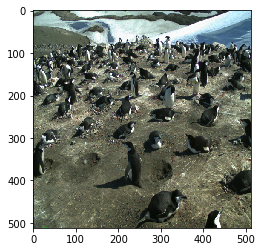

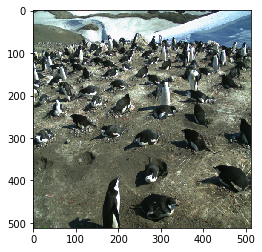

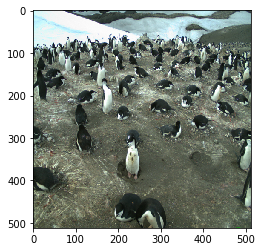

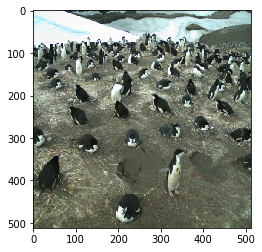

In [11]:
for i,peng_tensor in enumerate(iter(penguins)):
    peng_img = tensor2img(peng_tensor.unsqueeze(0))
    plt.imshow(peng_img)
    plt.show()
    if i == 3:
        break

In [12]:
##############################################################################################
# Encoder & RPNs
##############################################################################################

In [13]:
def backbone_forward(images, backbone):
    features = backbone(images.tensors)
    return OrderedDict([('0', features)])   

In [14]:
def rpn_forward(images, features, targets=None):
    # FORWARDS
    features = list(features.values())
    objectness, pred_bbox_deltas = rpn.head(features)
    anchors = rpn.anchor_generator(images, features)

    
    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    # RPN predicts bbox_deltas (wrt to anchors) & objectness
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = \
        concat_box_prediction_layers(objectness, pred_bbox_deltas)
    
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    # https://github.com/pytorch/vision/blob/819b2e9f39648711ab06562fc8f03ad001cf10be/torchvision/models/detection/rpn.py#L368
    
    # Boxes, scores are filtered foreground proposals for ROI Head
    # Not used for RPN loss
    boxes, scores = rpn.filter_proposals(
        proposals, objectness, images.image_sizes, num_anchors_per_level)
        
    return boxes, scores

In [15]:
def generate_box_features(data_i, top_bottom_n=256):
    data_i = data_i.cuda(non_blocking=True)
    
    # Data has to be wrapped in this class
    images = ImageList(
        data_i, data_i.shape[0] * [(512, 512)])

    # Forwards
    # Backbone Features
    features = backbone_forward(images, backbone)
    # Note RPN box is detached!
    boxes, scores = rpn_forward(images, features)    
    
    # Use just top and bottom predictions (instead of all)
    if top_bottom_n:
        
        # Boxes
        boxes = [b[:top_bottom_n] for b in boxes]
        
        # Scores
        scores = [s[:top_bottom_n] for s in scores]   
        
    # ROI Align (get features in predicted rpn_box)
    box_features = box_roi_pool(features, list(boxes), images.image_sizes)
    # Pool features into 1-DIM: Input for k-means and classifier
    box_features = box_head(box_features)

    return box_features, scores, boxes, images

In [16]:
for i, data_i in enumerate(dataloader):
    print(data_i.shape)
    break

torch.Size([4, 3, 512, 512])


In [17]:
box_features, scores, boxes, images = generate_box_features(
    data_i, 
    top_bottom_n=256
)

In [18]:
box_features.shape

torch.Size([1024, 1280])

In [19]:
##############################################################################################
# Self-Sim Matrix
##############################################################################################

In [20]:
ssm = squareform(pdist(box_features.cpu().detach().numpy(), lambda u,v: 1/(1+euclidean(u,v))))

In [41]:
# Highest-row
how_many_boxes = 3
top_box_indices = ssm[ssm.sum(axis=1).argmax()].argsort()[-how_many_boxes:][::-1]

In [42]:
##############################################################################################
# Viz for first image
##############################################################################################

In [43]:
top_boxes_im1 = list(filter(lambda x: 256<=x<(256+256), top_box_indices))

In [44]:
top_boxes_im1

[336, 481, 267]

In [45]:
######### Viz boxes

In [27]:
boxes = torch.cat(boxes)

In [28]:
# E.g. Most common boxes seem to be for 

In [46]:
def viz_prediction(boxes, im):
    im_tensor = im.unsqueeze(0)
    print(im_tensor.shape)
    im = tensor2img(im_tensor).copy()
    bb = boxes.cpu().data
    for (x1,y1,x2,y2) in bb:
        print(x1,y1,x2,y2)
        cv2.rectangle(im, (x1, y1), (x2, y2), (0,255,0), 2)
    plt.imshow(im)
    plt.show()

torch.Size([1, 3, 512, 512])
tensor(236.8150) tensor(90.7117) tensor(512.) tensor(444.1971)
tensor(262.3112) tensor(125.8028) tensor(496.5308) tensor(495.1694)
tensor(82.2352) tensor(189.2761) tensor(449.3966) tensor(432.3659)


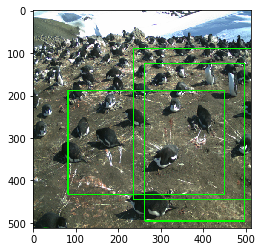

In [47]:
viz_prediction(
    boxes = torch.stack([boxes[b] for b in top_boxes_im1]),
    im = images.tensors[1]
)